In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import joblib

In [2]:
data = pd.read_csv("/content/housing_prices.csv")

In [3]:
data.head()

,Square_Feet,Bedrooms,Age,Location_Rating,Price
0,1360,2,11,7.017154,600672
1,4272,3,31,7.108030,560878
2,3592,1,95,4.257280,676665
3,966,1,91,6.342947,566043
4,4926,2,12,1.091181,593599


In [4]:
data.isnull().sum()

,0
Square_Feet,0
Bedrooms,0
Age,0
Location_Rating,0
Price,0


In [5]:
data.duplicated().sum()

0

In [6]:
data.shape

(1000, 5)

In [7]:
data.describe()

,Square_Feet,Bedrooms,Age,Location_Rating,Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,2815.422000,2.990000,48.414000,5.483500,6.044307e+05
std,1255.514921,1.427564,29.183699,2.589672,1.814169e+05
min,503.000000,1.000000,0.000000,1.000105,1.087100e+05
25%,1749.500000,2.000000,22.000000,3.335411,4.775332e+05
50%,2862.500000,3.000000,47.000000,5.502313,6.003425e+05
75%,3849.500000,4.000000,74.000000,7.677870,7.320828e+05
max,4999.000000,5.000000,99.000000,9.980388,1.039240e+06


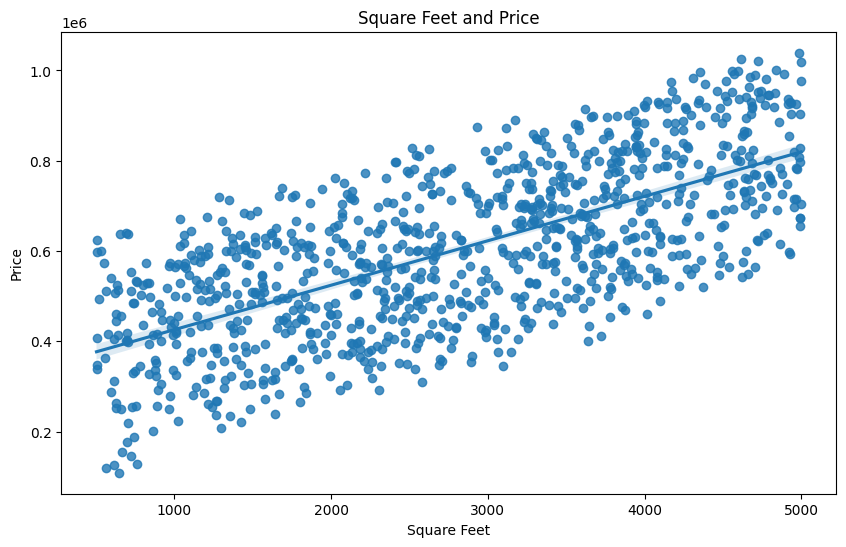

In [8]:
plt.figure(figsize=(10, 6))
sns.regplot(x=data['Square_Feet'], y=data['Price'])
plt.title('Square Feet and Price')
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.show()
# from the plot there is strong relation between both

In [9]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [10]:
housing_data = remove_outliers(data, 'Square_Feet')
housing_data = remove_outliers(housing_data, 'Age')
housing_data = remove_outliers(housing_data, 'Price')

In [11]:
housing_data.shape                  #as the shape still the same so no outliers

(1000, 5)

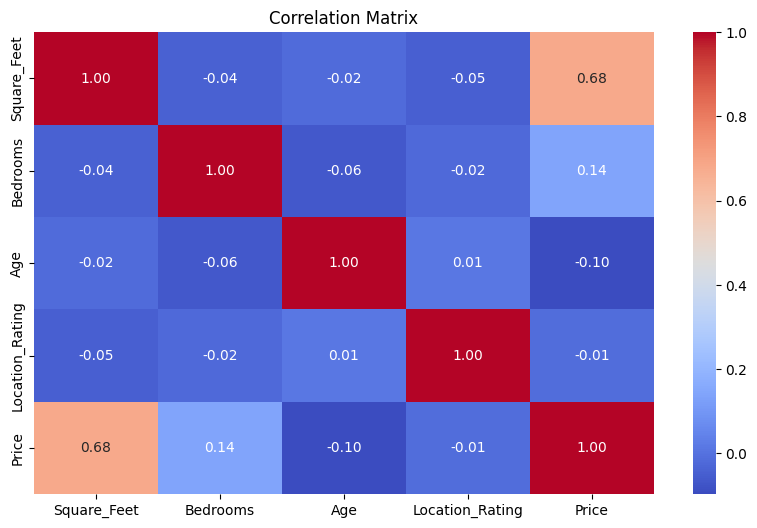

In [12]:
correlation_matrix = housing_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [13]:
## From the above corelation matrix we see that price is high correlated with the size and low with Location rating so we can drop it as it will not affect it so much
housing_data = housing_data.drop(columns=['Location_Rating'])

In [14]:
### Feature Engineering
# housing_data['Price_per_Square_Feet'] = housing_data['Price'] / housing_data['Square_Feet']
housing_data['Price'] = np.log(housing_data['Price'])

In [16]:
scaler = MinMaxScaler()
features_to_normalize = ['Square_Feet', 'Age']
housing_data[features_to_normalize] = scaler.fit_transform(housing_data[features_to_normalize])


In [17]:
X = housing_data.drop(columns=['Price'])
y = housing_data['Price']

In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # i made this x_temp and y_temp to split it after that to val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
X_train.shape[1]   # the number of features (input of the nn)

3

In [20]:
print(X_train.dtypes)


Square_Feet    float64
Bedrooms         int64
Age            float64
dtype: object


In [21]:

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [23]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='linear'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 171.0967 - mae: 13.0660 - val_loss: 138.4951 - val_mae: 11.7408
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 127.1968 - mae: 11.2311 - val_loss: 98.4067 - val_mae: 9.7973
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 86.7429 - mae: 9.1199 - val_loss: 55.1607 - val_mae: 6.9522
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 41.6821 - mae: 5.8112 - val_loss: 26.3958 - val_mae: 4.2829
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21.7170 - mae: 3.8898 - val_loss: 21.8363 - val_mae: 4.1603
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19.3668 - mae: 3.8281 - val_loss: 20.0833 - val_mae: 3.9689
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.5528 - mae: 3.6216 - val_loss: 18.4397 - val_mae: 3.7727
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6933 - mae: 3.3921 - val_loss: 16.7928 - val_mae: 3.5841
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━

In [25]:
predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 0.06931007960075622
Mean Absolute Error: 0.20544431741200844


In [27]:
model.save('housing_price_model.h5')


In [28]:
joblib.dump(scaler, 'scaler.save')

['scaler.save']